In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Data_for_bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns

In [4]:
tick_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']

## grid based search

In [16]:
ladder_sizing_grid = np.array([0.001,0.003,0.005,0.007,0.009])
print(ladder_sizing_grid)
position_sizing_grid = np.arange(100000,1000000,200000)
print(position_sizing_grid)

[0.001 0.003 0.005 0.007 0.009]
[100000 300000 500000 700000 900000]


In [25]:
# heat map of profits for different ladder sizing and position sizing
def profit_map(tick_data,ladder_sizing,position_sizing):
    profits = np.zeros((len(ladder_sizing),len(position_sizing)))
    U_PNLs = np.zeros((len(ladder_sizing),len(position_sizing)))
    max_positions = np.zeros((len(ladder_sizing),len(position_sizing))) 
    R_PNLs = np.zeros((len(ladder_sizing),len(position_sizing)))
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,ladder_sizing[i],position_sizing[j])
            profits[i,j]=profit
            U_PNLs[i,j]=U_PNL
            max_positions[i,j]=max_position
            R_PNLs[i,j]=R_PNL
    return profits,U_PNLs,max_positions,R_PNLs

def profit_heat_map(profits, ladder_sizing, position_sizing,title):
    plt.figure(figsize=(10,10))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True,alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, ladder_sizing)
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title(title+' Heat Map')
    plt.show()


In [12]:
profits,U_PNLs,max_positions,R_PNLs = profit_map(tick_data,ladder_sizing_grid,position_sizing_grid)

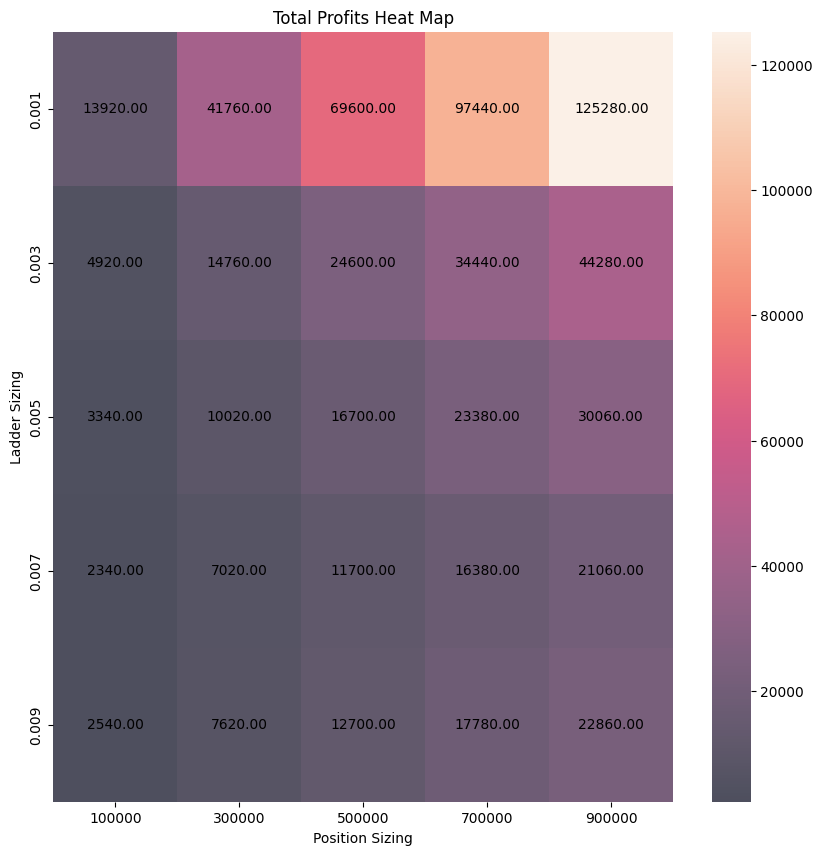

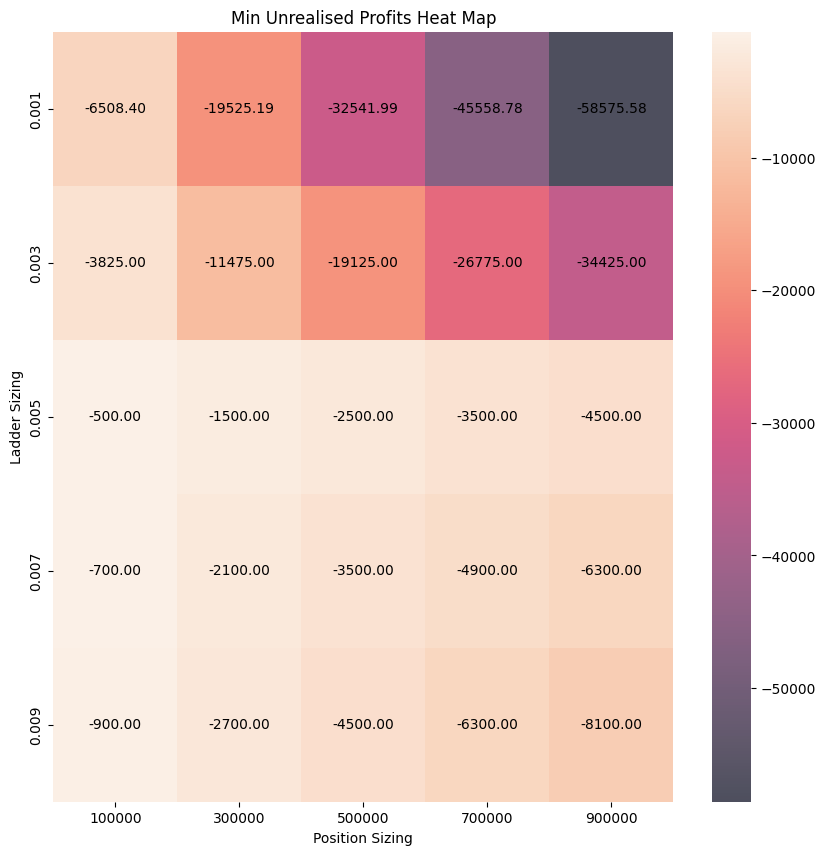

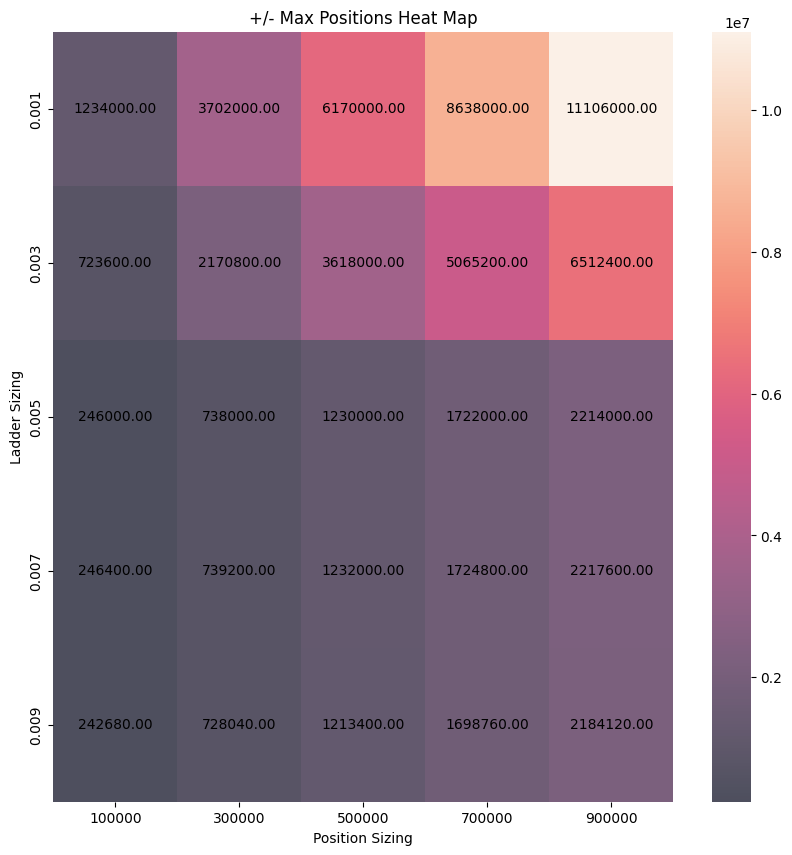

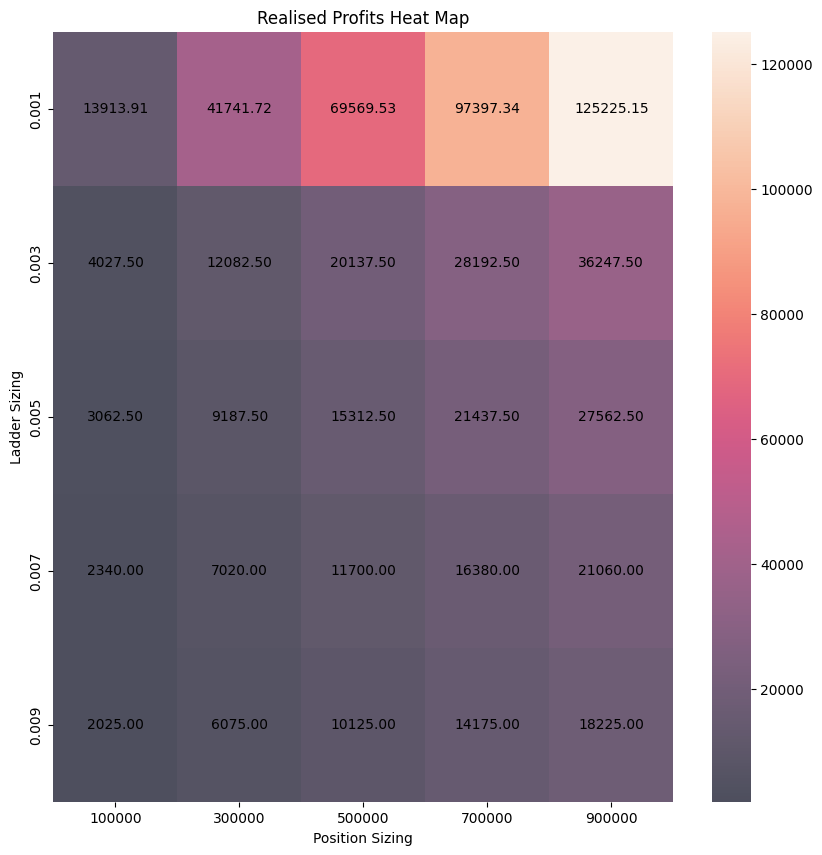

In [26]:
profit_heat_map(profits,ladder_sizing_grid,position_sizing_grid,'Total Profits')
profit_heat_map(U_PNLs,ladder_sizing_grid,position_sizing_grid,'Min Unrealised Profits')
profit_heat_map(max_positions,ladder_sizing_grid,position_sizing_grid,'+/- Max Positions')
profit_heat_map(R_PNLs,ladder_sizing_grid,position_sizing_grid,'Realised Profits')

In [33]:
trades = run_strategy_optimised(tick_data,0.001,900000,10)

## scipy 

In [35]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'SLSQP',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [36]:
print(' for scipy optimization with SLSQP, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

 for scipy optimization with SLSQP, the optimal G and optimal_n is:  0.005 500000.0 with profit 15312.5


In [ ]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'trust-constr',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [ ]:
print(' for scipy optimization with trust-constr optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)


In [ ]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'COBYLA',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [ ]:
print(' for scipy optimization with COBYLA, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)


In [ ]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'TNC',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [ ]:
print(' for scipy optimization with TNC, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

cut

In [ ]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'BFGS',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [ ]:
print(' for scipy optimization with BFGS, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

## optuna

In [ ]:
tick_data = data_gather_from_files('1 jan 2021','31 Dec 2021')['EURUSD.mid']

In [47]:
import optuna

def objective_optuna(trial, tick_data):
    G = trial.suggest_float("G", 0.001, 0.01)
    n = trial.suggest_float("n", 100000, 10000000)
    
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    
    # Constraints
    if max_position > 10e6:
        return float('inf')
    if U_PNL < -150e3:
        return float('inf')
    return -R_PNL  # We negate the value since we want to maximize ProfitD

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=30)

optimal_G = study.best_params["G"]
optimal_n = study.best_params["n"]


[I 2023-09-20 21:38:17,635] A new study created in memory with name: no-name-a4323859-9576-492d-92e8-61ed29ab5da4


In [43]:
optimal_G, optimal_n, - study.best_value

(0.004490608997147037, 2543348.495464038, 123267.6237)

## visualisation after finding optimal G and n

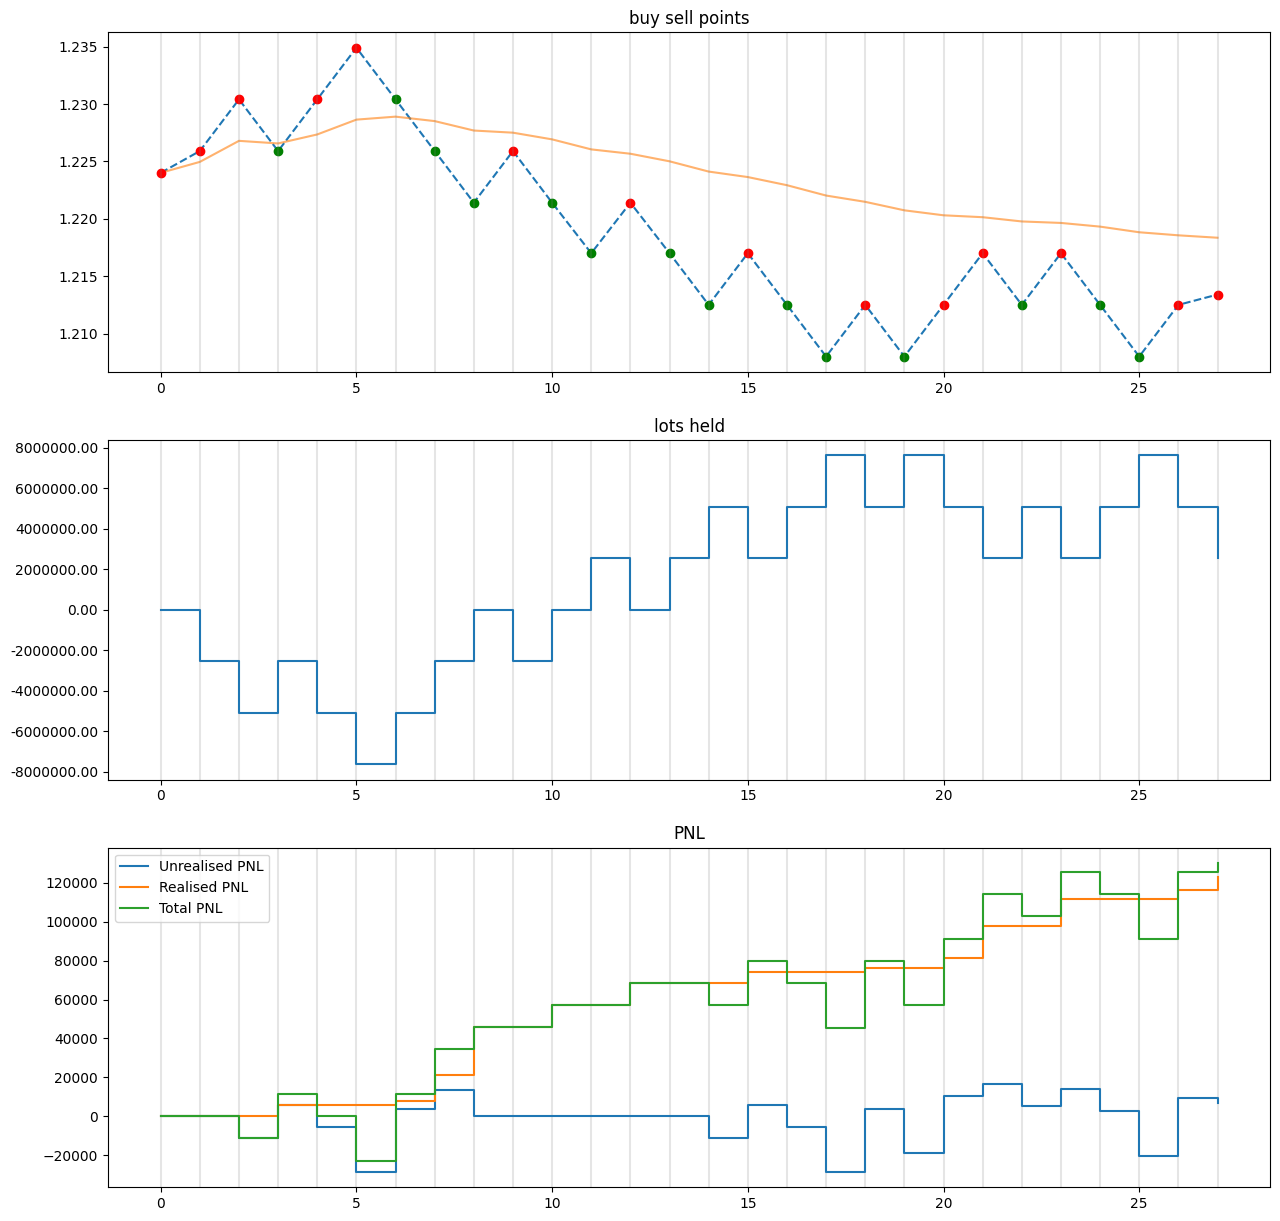

TypeError: cannot unpack non-iterable Styler object

In [46]:
_,a,b,c,d,e,f,g = run_strategy_eval(tick_data,optimal_G,optimal_n,trade_plot=True)
print('final profit is: ',a)
print('realised profit is: ',b)
print('final unrealised profit is: ',c)
print('max long lots held is: ',d)
print('max short lots held is :',e)
print('max long position is: ',f)
print('max short position is :',g)